In [726]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score, accuracy_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import StandardScaler, PowerTransformer

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

%matplotlib inline

In [727]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [728]:
login_df = pd.read_json('logins.json')
login_df.set_index('login_time',inplace=True)
login_df['freq']=np.ones(login_df.shape[0])

In [729]:
login_df.head()

,freq
login_time,
1970-01-01 20:13:18,1.0
1970-01-01 20:16:10,1.0
1970-01-01 20:16:37,1.0
1970-01-01 20:16:36,1.0
1970-01-01 20:26:21,1.0


In [730]:
login_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93142 entries, 1970-01-01 20:13:18 to 1970-04-13 18:54:23
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   freq    93142 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB


# Part 1 ‐ Exploratory data analysis 

1. Aggregate these login counts based on 15minute time intervals, and 
2. visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. 
3. Please report/illustrate important features of the demand, such as daily cycles. 
4. If there are data quality issues, please report them.

In [731]:
login_agg_15_df=pd.DataFrame(login_df.groupby([pd.Grouper(freq='15Min')]).sum())
login_agg_15_df.head()

,freq
login_time,
1970-01-01 20:00:00,2.0
1970-01-01 20:15:00,6.0
1970-01-01 20:30:00,9.0
1970-01-01 20:45:00,7.0
1970-01-01 21:00:00,1.0


Text(0.5, 0, 'hour of a day')

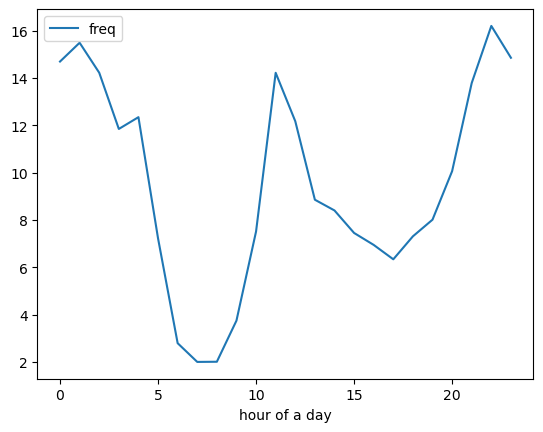

In [732]:
login_agg_15_df.groupby(login_agg_15_df.index.hour).mean().plot()
plt.xlabel("hour of a day")

    During a day, the highest demand is in the early morning (at around 1am) and in late night (at around 10pm). It could       be because the public transportation services stop operating then. Another high demand hour is at around noon when         people are out running their daily activities and business are functioning. The lowest demand of service is at morning     7-8am and afternoon 5-6pm when it is rush hours. People either utilize public transportation to avoid traffic or  avoid     traffic completely by putting off activities to late. 

Text(1, 9, '0--Monday\n\n 1--Tuesday\n       .\n       .\n       .\n\n 6--Sunday')

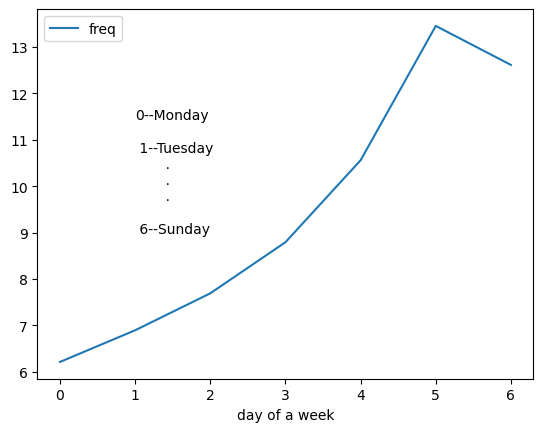

In [788]:
login_agg_15_df.groupby(login_agg_15_df.index.dayofweek).mean().plot()
plt.xlabel("day of a week")
plt.text(1,9, '0--Monday\n\n 1--Tuesday\n       .\n       .\n       .\n\n 6--Sunday')

In a weekly cycle (Monday through Sunday), the demand of service shows a non-liner increasing trend. The highest demand is at the weekend, which is understandable. People are outing and have more transprotation needs. 

Text(0.5, 0, 'day of a month')

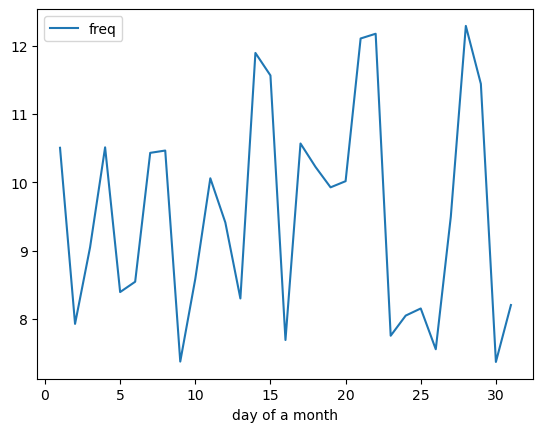

In [734]:
login_agg_15_df.groupby(login_agg_15_df.index.day).mean().plot()
plt.xlabel("day of a month")

    In a monthly cycle, the demand of service on average is stable. However, the variation in demand of service is              increasing from the beginning of month to the end. It could be that by the end of month people's spending behaviors        have more variation than at hte beginning of month. Some people have spent their monthly means and try to avoid outing      due to financial constraint. Some people, however, have more outing towards to the end of month because of a whole-        month stress from work, family and other factors. 

# Part 2 ‐ Experiment and metrics design 
1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric? 
2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. 
3) Please provide details on: 
       a) how you will implement the experiment
       b) what statistical test(s) you will conduct to verify the significance of the observation 
       c) interpret the results and provide recommendations to the city operations team along with any caveats.
       

\n       
       
       a) I would run a pilot study first before full implementation of the strategy. For example, we could run a week-long           single-blinded balanced experiment on 200 drives, with 100 each in treat/control group. In the treat group we               would offer each driver amount of money equivalent to the toll fees for two round-trips between  Gotham and                 Metropolis and for the control group, no such incentive is provided.   We then install a GPS tracker on each               driver's service vehicle and ask drivers to leave GPS on for the entire two-week study period. 
       
       b)At the end of study we want to compare the average between-city trips taken during the study period between two            study groups. We then run a two-sample t-test to comapred the two means with a pre-determined effect size.
       
       c) if the diference between two averages is statistically significantly higher than the pre-determined effect size,           then we consdierd the company's strategy effective, we can then safely implement the reimbursement marketing               stretegy. 
       

# Part 3 ‐ Predictive modeling

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained? 
   
                active:   0.691265    inactive: 0.308735
                
     
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance. 

                I applied LogisticRegression classification. It is a binary classification problem and Logsitcregression                   works well with binary classfication. I also did hyperparameter tuning to find the best regulariation 
                parameter for model to avoid overwriting. 
                   
                   
                             precision    recall  f1-score   

                  inactive       0.77      0.86      0.81      
                    active       0.70      0.55      0.62      

                  accuracy                           0.75      
                 macro avg       0.74      0.71      0.72      

To improve the model performance, as an alternative, I also applied RandomForest classification for comparison. However, there is no much improvement in term of prediction accuracy. So the next step to take to improve model performance is feature engineering: for example, we might need to include membership info


3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice)

       1). city "King's Landing" is most important feature in predicting retention, so Ultimate Inc can till focus 
           on promotion in King's Landing and maintain or boost market share in King's Landing, but also work harder 
           on promoting services the other two cities to increase their market share in these two cities. 
       2). Phone version is the second most important feature, which is possibly due to company's iPhone app is easier
           to use than the android version. So the company can work on improve the user interface of their apps. 
       3). Users who have tried Ultimate_black service are more likely to retent. So the company can also try to 
           promote their Ultimate Black service with discounts, incentives, etc. 
       4). another thing the company could also try is to collect memembership, to see if the retention rate would
           be improved

## Cleaning data

In [735]:
challenge_df = pd.read_json('ultimate_data_challenge.json')
#login_df.set_index('login_time',inplace=True)
#login_df['freq']=np.ones(login_df.shape[0])

In [736]:
challenge_df.head(100)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
95,Astapor,1,2014-01-23,NaN,1.00,2014-01-23,iPhone,0.0,True,100.0,1.35,4.0
96,Winterfell,11,2014-01-26,4.1,1.00,2014-07-01,iPhone,1.9,True,76.9,4.89,4.6
97,Astapor,4,2014-01-07,5.0,1.00,2014-01-11,Android,0.0,True,75.0,5.36,5.0
98,King's Landing,1,2014-01-18,4.3,1.02,2014-06-19,iPhone,10.0,False,90.0,4.20,5.0


In [737]:
challenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [738]:
challenge_df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [739]:
print(challenge_df.nunique())

city                         3
trips_in_first_30_days      59
signup_date                 31
avg_rating_of_driver        37
avg_surge                  115
last_trip_date             182
phone                        2
surge_pct                  367
ultimate_black_user          2
weekday_pct                666
avg_dist                  2908
avg_rating_by_driver        27
dtype: int64


### 1.  drop rows with phone missig and drop duplicated rows

In [740]:
#drop rows with phone info missing
challenge_df.dropna(subset='phone',inplace=True)

In [741]:
#check on duplicated rows (there are 8 records are duplicated)
challenge_df.duplicated().sum()

8

In [742]:
#drop duplicated rows
challenge_df.drop_duplicates(inplace=True)
challenge_df.shape

(49596, 12)

### 2.  impute missing data

In [743]:
hist_plot_columns=['avg_rating_of_driver','avg_rating_by_driver']

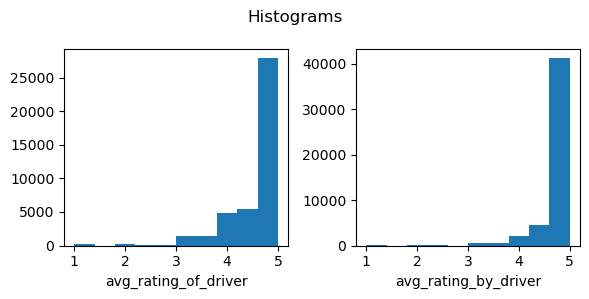

In [744]:
rows, cols = 1, 2
fig, ax = plt.subplots(rows, cols,figsize=(6,3))


for col in range(cols):
    i=col        
    ax[col].hist(challenge_df[hist_plot_columns[i]])
    ax[col].set(xlabel=hist_plot_columns[i])

plt.suptitle('Histograms')          
plt.tight_layout(w_pad=1)
plt.show()

In [745]:
challenge_df.avg_rating_by_driver.median()

5.0

In [746]:
#since both 'avg_rating_of_driver', 'avg_rating_by_driver' are skewed distributed, 
#we will use medians to impute missing data

challenge_df.fillna(value={'avg_rating_of_driver':challenge_df.avg_rating_of_driver.median(), 
                           'avg_rating_by_driver':challenge_df.avg_rating_by_driver.median()}, inplace=True)

### 3.  define target variable 'retention', 'age' and 'last_trip_age' variable

  note: 1) 'age' is calculated as diff=days between this_day & signup_date
  
  2) 'last_trip_age' is calculated as diff=days between this_day & last_trip_date

In [747]:
challenge_df['last_trip_date']=pd.to_datetime(challenge_df['last_trip_date']) 

In [748]:
challenge_df['signup_date']=pd.to_datetime(challenge_df['signup_date']) 

In [749]:
challenge_df['user_age']=(challenge_df.last_trip_date.max()-challenge_df.signup_date).dt.days

In [750]:
challenge_df['last_trip_age']=(challenge_df.last_trip_date.max()-challenge_df.last_trip_date).dt.days

In [751]:
challenge_df['retention']=challenge_df['last_trip_age'].apply( lambda x: 1 if x<30 else 0 )

In [752]:
challenge_df.retention.value_counts()

0    31416
1    18180
Name: retention, dtype: int64

In [753]:
challenge_df.drop(columns=['signup_date','last_trip_date'],axis=1,inplace=True)

In [754]:
challenge_df.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,user_age,last_trip_age,retention
0,King's Landing,4,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,157,14,1
1,Astapor,0,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,153,57,0
2,Astapor,3,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0,176,175,0
3,King's Landing,9,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,172,2,1
4,Winterfell,14,4.4,1.19,Android,11.8,False,82.4,3.13,4.9,155,108,0


## EDA

In [755]:
heatmap_col=['avg_rating_of_driver', 'avg_surge','surge_pct', 'weekday_pct',
             'avg_dist', 'avg_rating_by_driver','user_age', 'last_trip_age']

Text(12, 6, 'Only strength of \n\n correlations >= 0.2\n\n are plotted')

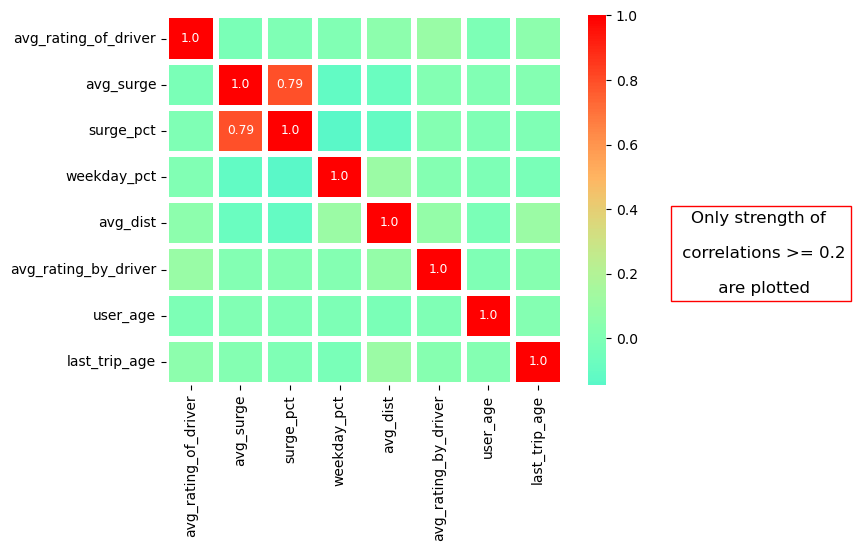

In [756]:
# Generate annotation labels array (of the same size as the heatmap data)- filling cells you don't want to annotate with an empty string ''
corr_df=challenge_df[heatmap_col].corr()
annot_labels = np.empty_like(corr_df, dtype=float)

rows,cols=corr_df.shape

for i in range(rows):
    for j in range(cols):
        val=corr_df.iloc[i,j]
        if (val>=0.2 or val<= -0.2):
            annot_labels[i,j]=val
        else: 
            annot_labels[i,j]=np.nan
annot_labels=np.round(annot_labels,2)
annot_labels = np.where(np.isnan(annot_labels), '', annot_labels)

g=sns.heatmap(corr_df, annot=annot_labels, linewidths=3, center=0,\
            cmap='rainbow',fmt='', annot_kws={"size": 25 / np.sqrt(len(corr_df))});
g.text(x=12,y=6,s="Only strength of \n\n correlations >= 0.2\n\n are plotted",horizontalalignment='center',
       fontsize='large',bbox=dict(facecolor='none', edgecolor='red'))
#
#plt.savefig('heatmap.png',dpi=100)

In [757]:
#drop avg_surge due to the high corelaton between avg_surge with surge_pct
challenge_df.drop(columns='avg_surge',axis=1,inplace=True)

In [758]:
def barplot_cat(x="retention", y="proportion", hue=hue):
    (challenge_df[hue]
     .groupby(challenge_df[x])
     .value_counts(normalize=True)
     .rename(y)
     .reset_index()
     .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

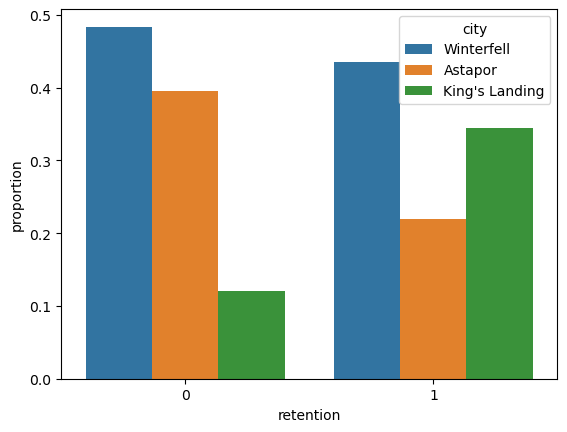

In [759]:
hue='city'
barplot_cat(hue=hue)

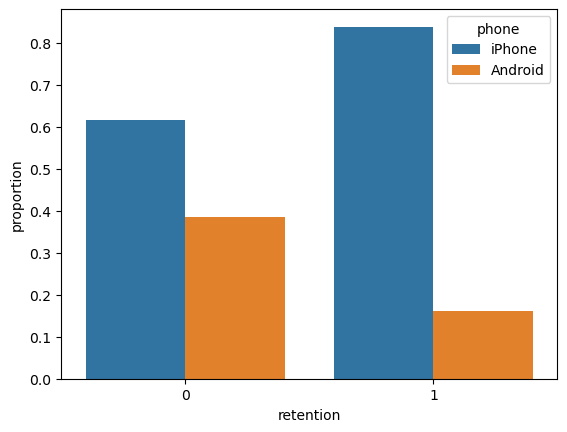

In [760]:
hue = "phone"
barplot_cat(hue=hue)

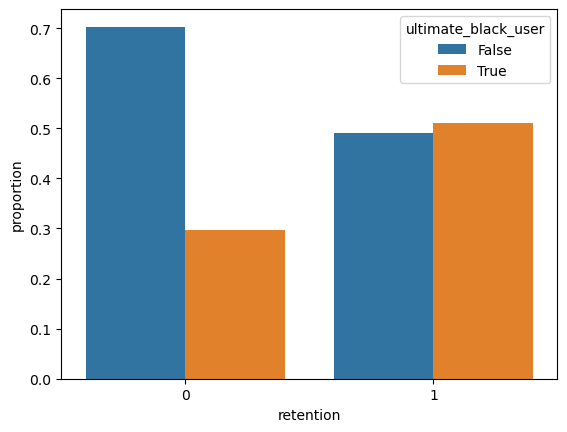

In [761]:
hue = "ultimate_black_user"
barplot_cat(hue=hue)

In [762]:
def barplot_num(x="retention", y=y):
    sns.catplot(x=x,y=y,data=challenge_df, kind='box',showfliers = False)

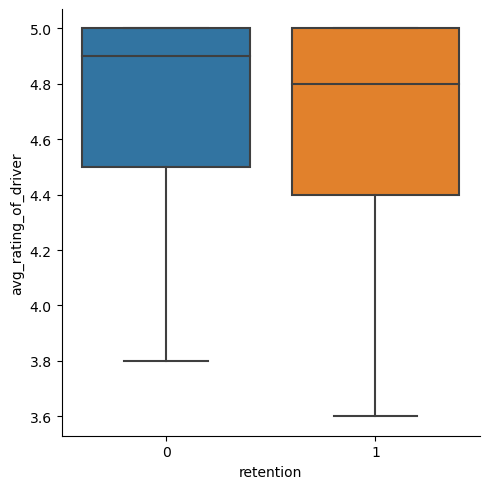

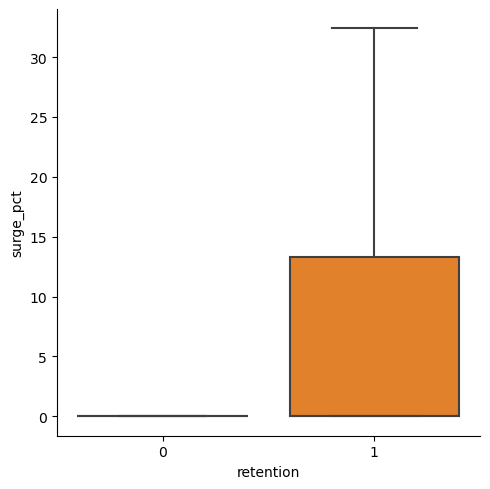

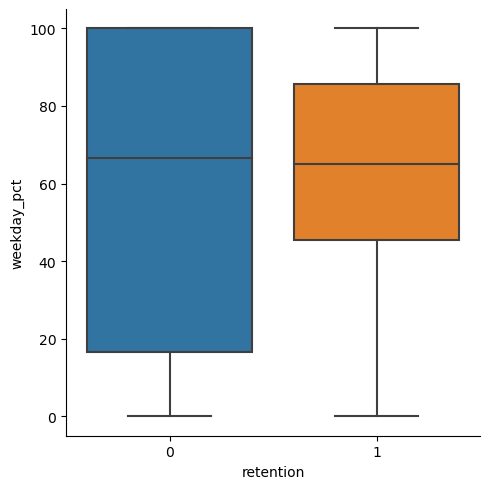

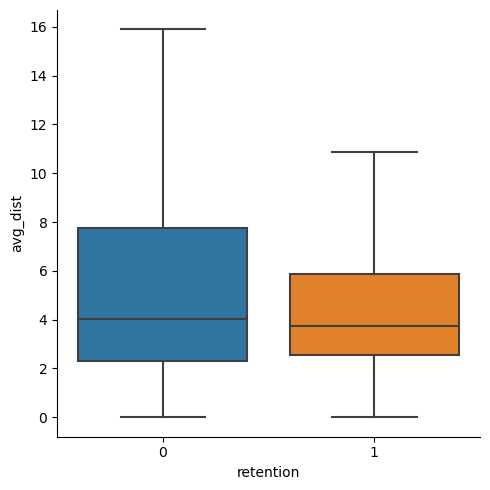

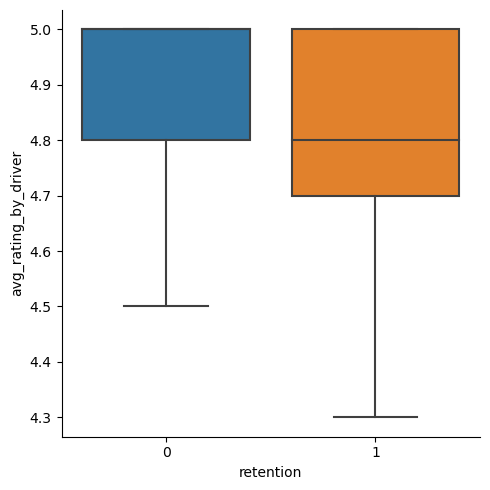

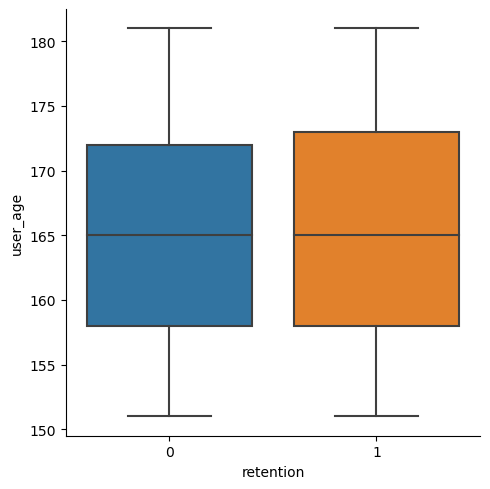

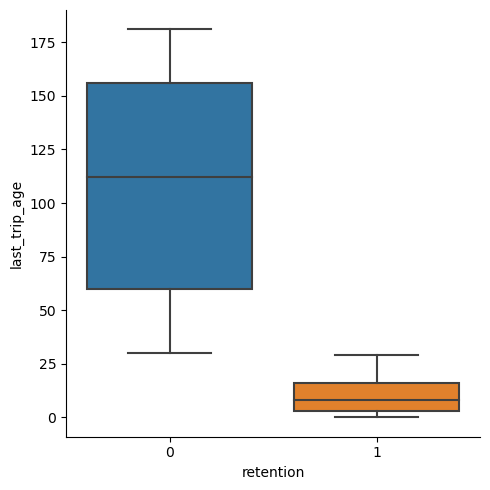

In [763]:
cols=['avg_rating_of_driver',  'surge_pct', 'weekday_pct', 
      'avg_dist', 'avg_rating_by_driver','user_age', 'last_trip_age']

for y in cols:
    barplot_num(y=y)   

## Pre-processing 

In [764]:
cols=['city','phone','ultimate_black_user']                   
challenge_df=pd.get_dummies(challenge_df,drop_first=True,columns=cols,dtype=float)

In [765]:
challenge_df.head()

,trips_in_first_30_days,avg_rating_of_driver,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,user_age,last_trip_age,retention,city_King's Landing,city_Winterfell,phone_iPhone,ultimate_black_user_True
0,4,4.7,15.4,46.2,3.67,5.0,157,14,1,1.0,0.0,1.0,1.0
1,0,5.0,0.0,50.0,8.26,5.0,153,57,0,0.0,0.0,0.0,0.0
2,3,4.3,0.0,100.0,0.77,5.0,176,175,0,0.0,0.0,1.0,0.0
3,9,4.6,20.0,80.0,2.36,4.9,172,2,1,1.0,0.0,1.0,1.0
4,14,4.4,11.8,82.4,3.13,4.9,155,108,0,0.0,1.0,0.0,0.0


## Train Model 

In [766]:
challenge_df['retention'].value_counts()/challenge_df.shape[0]

0    0.633438
1    0.366562
Name: retention, dtype: float64

In [767]:
X=challenge_df.drop(columns=['retention','user_age', 'last_trip_age'],axis=1)
y=challenge_df['retention']

In [768]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y,random_state=123)
print('X_train : ',X_train.shape)
print('X_test : ',X_test.shape)

unique,count=np.unique(y_train, return_counts=True)
print('train_test sets are splited with stratification: \n\t training set: {} '.format(count/len(y_train)))
unique1,count1=np.unique(y_test, return_counts=True)
print('train_test sets are splited with stratification: \n\t test set: {} '.format(count1/len(y_test)))

X_train :  (44636, 10)
X_test :  (4960, 10)
train_test sets are splited with stratification: 
	 training set: [0.6334349 0.3665651] 
train_test sets are splited with stratification: 
	 test set: [0.63346774 0.36653226] 


In [769]:
cols=['trips_in_first_30_days', 'avg_rating_of_driver', 'surge_pct','weekday_pct','avg_dist', 'avg_rating_by_driver']

scaler = PowerTransformer()
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])

### 1. Logistic Regression Model

In [770]:
logit_clf= LogisticRegression(penalty='l2',random_state = 0) 
logit_clf.fit(X_train,y_train)
y_pred=logit_clf.predict(X_test)

pl = confusion_matrix(y_test,y_pred)
print("Base Model : \n{}".format(pl))

print(classification_report(y_test,y_pred))

#dist=ConfusionMatrixDisplay(confusion_matrix=pl,display_labels=logit_clf.classes_)
#dist.plot()

Base Model : 
[[2710  432]
 [ 812 1006]]
              precision    recall  f1-score   support

           0       0.77      0.86      0.81      3142
           1       0.70      0.55      0.62      1818

    accuracy                           0.75      4960
   macro avg       0.73      0.71      0.72      4960
weighted avg       0.74      0.75      0.74      4960



### 2. LogisticRegresssion with hyperparameter tuning

In [771]:
param_grid = {'C':np.linspace(0.001,2.1,50)}
#instantiate and fit grid search object
grid = GridSearchCV(logit_clf,param_grid,cv=5)
grid.fit(X_train,y_train)

y_pred=grid.predict(X_test)
pl = confusion_matrix(y_test,y_pred)

print("Logit Model with Hyper-params Tuning: \n{}".format(classification_report(y_test,y_pred)))
print('\n')
print("Best Parameters: \n{}".format(grid.best_params_))

Logit Model with Hyper-params Tuning: 
              precision    recall  f1-score   support

           0       0.77      0.86      0.81      3142
           1       0.70      0.55      0.62      1818

    accuracy                           0.75      4960
   macro avg       0.74      0.71      0.72      4960
weighted avg       0.74      0.75      0.74      4960



Best Parameters: 
{'C': 0.043836734693877555}


Text(0, 0.5, 'Relative Importance')

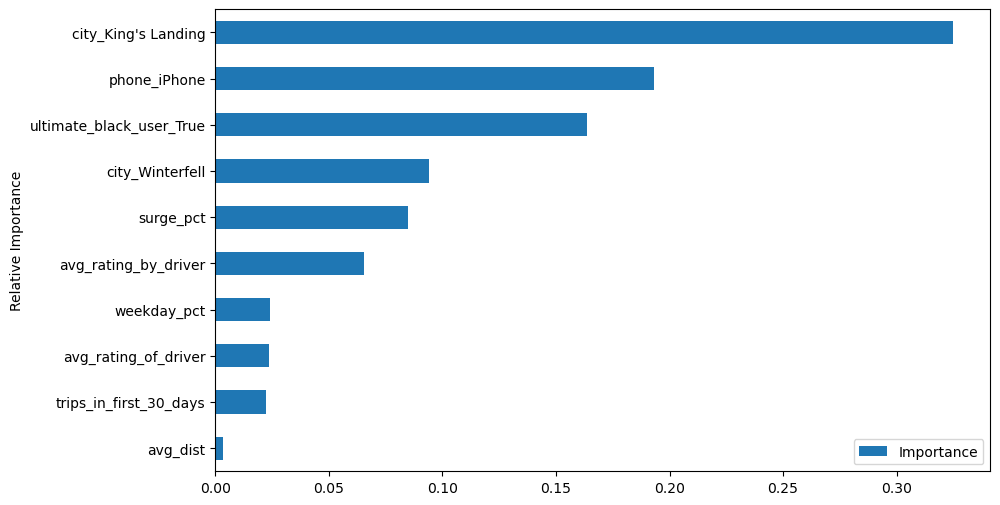

In [772]:
##feature importance plot

model = grid.best_estimator_
model.fit(X_train, y_train)

coefficients = model.coef_

avg_importance = np.mean(np.abs(coefficients), axis=0)
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': avg_importance/np.sum(avg_importance)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.ylabel('Relative Importance')

### 3. RandomForestClassifier 

RandomeForest Model : 
[[2569  573]
 [ 590 1228]]
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      3142
           1       0.68      0.68      0.68      1818

    accuracy                           0.77      4960
   macro avg       0.75      0.75      0.75      4960
weighted avg       0.77      0.77      0.77      4960



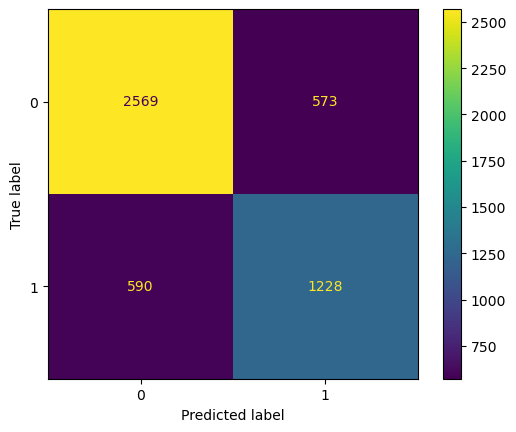

In [773]:
#build random forest model with 1000 estimators
rf_clf = RandomForestClassifier(n_estimators=1000)
rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)

pl = confusion_matrix(y_test,y_pred)
print("RandomeForest Model : \n{}".format(pl))

print(classification_report(y_test,y_pred))

dist=ConfusionMatrixDisplay(confusion_matrix=pl,display_labels=rf_clf.classes_)
dist.plot()